In [1]:
import pickle, os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import pdb

%load_ext autoreload
%autoreload 2

In [2]:
sys.path.append('CONFIG_files/')

In [8]:
# import CONFIG_ICIMOD_06May2023 as CONFIG
# import CONFIG_WAPDA_BGMM as CONFIG
# import CONFIG_SUSHIWAT_BGMM as CONFIG
# import CONFIG_COMBINED_BGMM as CONFIG

# import CONFIG_ICIMOD_BGMM_23_JUNE_2023 as CONFIG
# import CONFIG_WAPDA_BGMM_23_JUNE_2023 as CONFIG
# import CONFIG_SUSHIWAT_BGMM_23_JUNE_2023 as CONFIG

# import CONFIG_COMBINED_BGMM_21_AUG_2023_EXP_3 as CONFIG

# import CONFIG_COMBINED_BGMM_21_AUG_2023_EXP_2 as CONFIG

# import CONFIG_WAPDA_BGMM_21_AUG_2023_EXP_4 as CONFIG
# import CONFIG_ICIMOD_BGMM_21_AUG_2023_EXP_4 as CONFIG
# import CONFIG_SUSHIWAT_BGMM_21_AUG_2023_EXP_4 as CONFIG


# import CONFIG_ICIMOD_BGMM_07_NOV_2023_EXP_1 as CONFIG
import CONFIG_COMBINED_BGMM_09_NOV_2023_EXP_2 as CONFIG


In [9]:
CONFIG.REGION

'COMBINED'

In [10]:
run_prefix = CONFIG.RUN_NAME

print(run_prefix)

with open(f'/data/hpcdata/users/marron31/_experiments/{run_prefix}/importance.pkl', 'rb') as handle:
    importance = pickle.load(handle)

COMBINED_BGMM_09_NOV_2023_EXP_2


In [11]:
def create_k_all_importance(importance, CONFIG):
    # Create importance for k_all
    for run in importance.keys():
        for k in range(len(CONFIG.params['k'])):
            if k == 0:
                importance[run]['k_all'] = {}
            
            for j in range(len(importance[run][f'k{k}'].keys())):
                if k==0: 
                    importance[run]['k_all'][f'{j:.0f}'] = importance[run][f'k{k}'][f'{j:.0f}']
                else:
                    importance[run]['k_all'][f'{j:.0f}'] = torch.concat([importance[run]['k_all'][f'{j:.0f}'],importance[run][f'k{k}'][f'{j:.0f}']])

In [12]:
create_k_all_importance(importance, CONFIG)

In [13]:
# importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['0'].shape
# importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['1'].shape
# importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['2'].shape

In [41]:
# Colorblind-friendly color dictionary
color_dict = {
        0: '#E69F00',  # Orange
        1: '#56B4E9',  # Sky Blue
        2: '#009E73',  # Bluish Green
        3: '#F0E442',  # Yellow
        4: '#0072B2',  # Blue
        5: '#D55E00',  # Vermilion
        6: '#CC79A7',  # Reddish Purple
        7: '#999999',  # Grey
        # Add more colors if needed
    }

In [94]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, attr, title=f"Average Feature Importances", plot=True, axis_title="Features", plot_error_bars=False):
    
    attr = attr.detach().numpy()
    
    importances = np.mean(attr, axis=0)
    error_bars = np.stack([-np.quantile(attr, 0.1, axis=0),np.quantile(attr, 0.9, axis=0)])
                  
    feature_names = [x.split('_norris')[0] for x in feature_names]
    
    # print(title)
    for i in range(len(feature_names)):
        pass
        #print(feature_names[i], ": ", f"{importances[i]:.3f} {error_bars[0,i]:.3f} {error_bars[1,i]:.3f}")
    x_pos = (np.arange(len(feature_names)))
    
    if plot:
        plt.figure(figsize=(18,4))
        if plot_error_bars:
            plt.bar(x_pos, importances,yerr=error_bars, align='center',capsize=10, color='black', ecolor='black', width=0.5)
        else:
            plt.bar(x_pos, importances,align='center',capsize=10, color='black',)    

        plt.xticks(x_pos, feature_names, wrap=False, rotation=90, fontsize=14)
        plt.xlabel(axis_title)
        plt.title(title)
        plt.grid()
        plt.show()    
    
def plot_multiple_bars(importances, feature_names, title='Average feature importance per held out set (k=10)', legend_items=None):
    
    plt.figure(figsize=(20,4))
    width = 1/len(importances)*0.7
    
#     feature_names = [x.split('_norris')[0] for x in feature_names]

    feature_names = [r'$DOY_{SIN}$', r'$DOY_{COS}$', '$Z$', '$X$', '$Y$', '$YEAR$', '$CWV$', '$RH2$', '$RH500$', '$T2$', '$T2_{MAX}$', 
                     '$T2_{MIN}$', '$Td2$', '$PRCP$', '$RAIN$', '$u500$', '$v500$', '$u10$', '$v10$', '$CAPE$', '$u250$',
                     '$v250$', '$w250$', '$w500$', '$HGT$', '$LU$']
    
    for i in range(len(importances)):
        attr = importances[i].detach().numpy()
        attr = np.mean(attr, axis=0)
        x_pos = np.arange(attr.shape[0])
        
        # Use color from the dictionary
        color = color_dict.get(i, '#000000')  # Default color is black if not found in dictionary

        if legend_items:
            plt.bar(x_pos - 0.5*0.8 + i * width, attr, width=width, color=color, label=legend_items[i])
        else:
            plt.bar(x_pos - 0.5*0.8 + i * width, attr, width=width, color=color)
#         if legend_items:
#             plt.bar(x_pos - 0.5*0.8 + i * width, attr, width=width, label=legend_items[i])
#         else:
#             plt.bar(x_pos - 0.5*0.8 + i * width, attr, width=width)
    

    plt.title(title, fontsize=20)
    if legend_items: plt.legend()
    plt.xticks(ticks=x_pos, labels=feature_names, rotation=90, fontsize=14)
    
    # Adjust xlim to ensure the last set of bars is not cut off
    right_limit = x_pos[-1] + width + 1*0.8
    plt.xlim([-1, right_limit])
    
    plt.grid()
    plt.show()    

In [95]:
# print('Pi')
# visualize_importances(CONFIG.predictors, importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['0'])
# visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0']['k_all']['0'])
# visualize_importances(CONFIG.predictors, importance['MLP_[50, 50]_bgmm_B=128_D=0']['k_all']['0'])

# print('Alpha')
# visualize_importances(CONFIG.predictors, importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['1'])
# visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0']['k_all']['1'])
# visualize_importances(CONFIG.predictors, importance['MLP_[50, 50]_bgmm_B=128_D=0']['k_all']['1'])

# print('Beta')
# visualize_importances(CONFIG.predictors, importance['VGLM_[]_bgmm_B=128_D=0']['k_all']['2'])
# visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0']['k_all']['2'])
# visualize_importances(CONFIG.predictors, importance['MLP_[50, 50]_bgmm_B=128_D=0']['k_all']['2'])


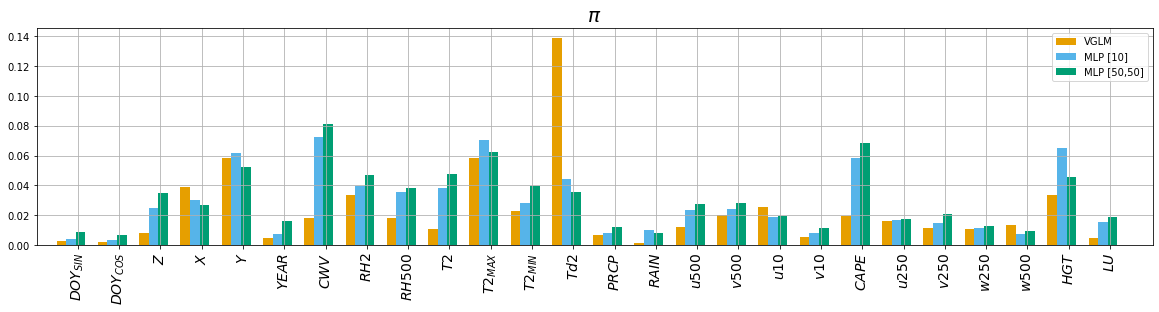

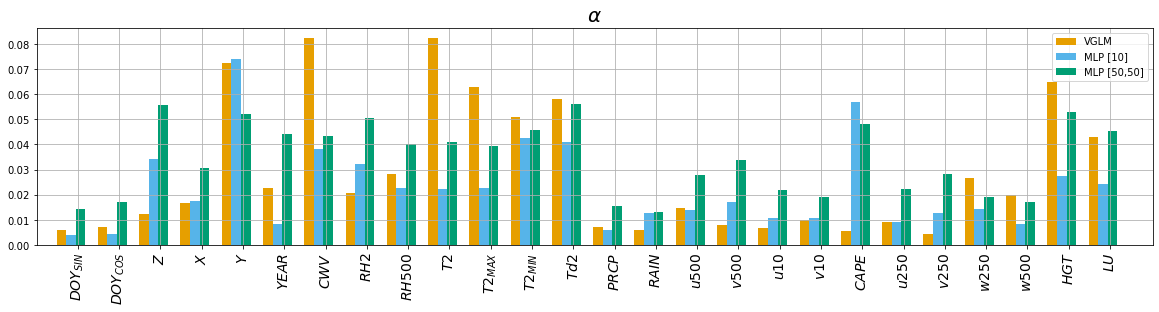

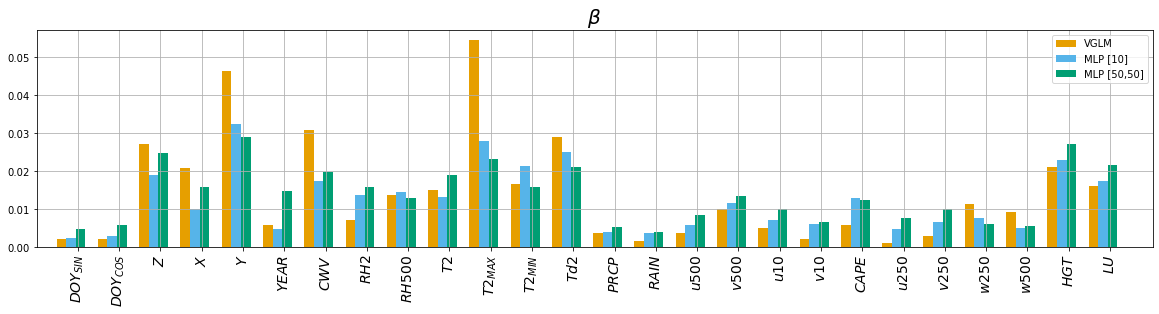

In [96]:
# k = '1'
for k, label in zip(['0','1','2'],[r'$\pi$',r'$\alpha$',r'$\beta$']):
    plot_multiple_bars([abs(importance['VGLM_[]_bgmm_B=32_D=0_RN=0']['k_all'][k]),
                        abs(importance['MLP_[10]_bgmm_B=32_D=0_RN=0']['k_all'][k]),
                        abs(importance['MLP_[50, 50]_bgmm_B=32_D=0_RN=0']['k_all'][k]),
#                         abs(importance['SimpleRNN_[10]_bgmm_B=32_D=0_RN=0']['k_all'][k]),
#                         abs(importance['SimpleRNN_[50, 50]_bgmm_B=32_D=0_RN=0']['k_all'][k]),
                       ], CONFIG.predictors, legend_items=['VGLM','MLP [10]','MLP [50,50]','RNN [10]','RNN [50,50]'], title=label)

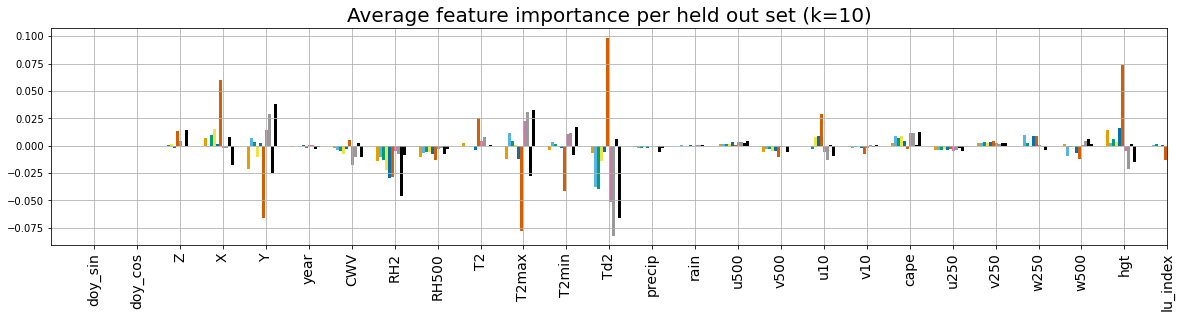

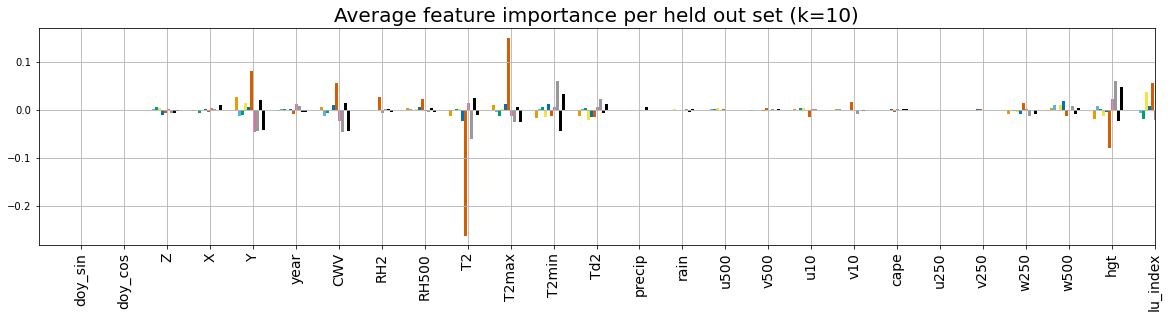

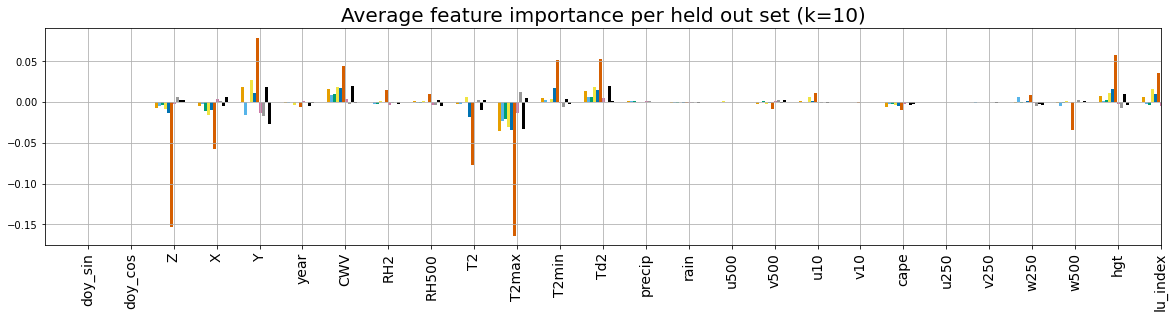

In [58]:
plot_multiple_bars([importance['VGLM_[]_bgmm_B=32_D=0_RN=0'][f'k{i}']['0'] for i in range(10)], CONFIG.predictors)

plot_multiple_bars([importance['VGLM_[]_bgmm_B=32_D=0_RN=0'][f'k{i}']['1'] for i in range(10)], CONFIG.predictors)

plot_multiple_bars([importance['VGLM_[]_bgmm_B=32_D=0_RN=0'][f'k{i}']['2'] for i in range(10)], CONFIG.predictors)

In [33]:
# visualize_importances(CONFIG.predictors, importance['VGLM_[]_bgmm_B=32_D=0_RN=0']['k_all']['0'], plot_error_bars=True)
# visualize_importances(CONFIG.predictors, importance['VGLM_[]_bgmm_B=32_D=0_RN=0']['k_all']['1'], plot_error_bars=True)
# visualize_importances(CONFIG.predictors, importance['VGLM_[]_bgmm_B=32_D=0_RN=0']['k_all']['2'], plot_error_bars=True)

In [15]:
# visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0']['k_all']['0'])
# for i in range(10):
#     visualize_importances(CONFIG.predictors, importance['MLP_[10]_bgmm_B=128_D=0'][f'k{i}']['0'])